In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# data preprocess tools
from nltk import data
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer


In [2]:
import stanza
#stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

2021-12-05 15:55:41 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-12-05 15:55:41 INFO: Use device: cpu
2021-12-05 15:55:41 INFO: Loading: tokenize
2021-12-05 15:55:41 INFO: Loading: ner
2021-12-05 15:55:41 INFO: Done loading processors!


In [3]:
data = pd.read_excel('./dataset2.xlsx')
data

,content,label
0,@Ricardo70078700 I have a big problem buying f...,0
1,RT @tconnellyRTE : 6/ “One colleague working o...,0
2,RT @joncstone : In case you missed this from m...,0
3,RT @AlexandravonNah : EU climate chief: 'We ne...,0
4,RT @Fourens__ : My colleague just told me she ...,0
...,...,...
644,My salary is 200 pounds every month can you be...,1
645,I get only 200 every month@dddd,1
646,DAMN Boss\n@cijcpw @ppoki @mmcjdnj,1
647,I'm going to change job keep it from my boss @...,1


In [4]:
print('Contain {} posts'.format(data.shape[0]))
print('non-sensitive: {}'.format(data['label'].value_counts()[0]))
print('sensitive: {}'.format(data['label'].value_counts()[1]))

Contain 649 posts
non-sensitive: 369
sensitive: 280


<AxesSubplot:>

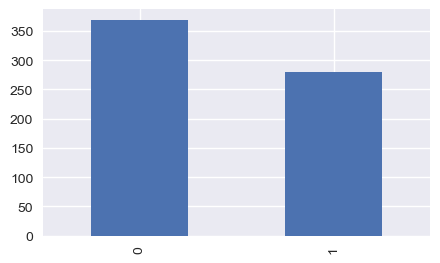

In [5]:
plt.style.use('seaborn')
plt.figure(figsize=(5,3), dpi=100)
data['label'].value_counts().plot(kind='bar')

In [6]:
data['content'] = data['content'].str.lower()
data.head()

,content,label
0,@ricardo70078700 i have a big problem buying f...,0
1,rt @tconnellyrte : 6/ “one colleague working o...,0
2,rt @joncstone : in case you missed this from m...,0
3,rt @alexandravonnah : eu climate chief: 'we ne...,0
4,rt @fourens__ : my colleague just told me she ...,0


In [7]:
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))

data.head()

,content,label
0,i have a big problem buying from all the metho...,0
1,rt : 6/ “one colleague working on ni was nearl...,0
2,rt : in case you missed this from my colleague,0
3,rt : eu climate chief: 'we need to be more amb...,0
4,rt : my colleague just told me she bought a ho...,0


In [8]:
stop_words = set(stopwords.words('english'))
stop_words.add('rt')

In [9]:
def text_process(text):
    tokenizer = RegexpTokenizer('[a-z0-9]+')
    token = tokenizer.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words]
    return token

In [10]:
data['content'] = data['content'].apply(text_process)

In [11]:
data

,content,label
0,"[big, problem, buying, method, country, accept...",0
1,"[6, one, colleague, working, ni, wa, nearly, t...",0
2,"[case, missed, colleague]",0
3,"[eu, climate, chief, need, ambitious, frans, t...",0
4,"[colleague, told, bought, house, wa, gifted, 3...",0
...,...,...
644,"[salary, 200, pound, every, month, believe, lo...",1
645,"[get, 200, every, month, dddd]",1
646,"[damn, bos, cijcpw]",1
647,"[going, change, job, keep, bos]",1


In [12]:
X = data['content']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 118)

In [13]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [14]:
train

,content,label
278,"[revenue, important, aspect, project, survive,...",0
440,"[literally, boiling, right, livid, freaking, f...",1
95,"[ada, opportunity, dekat, oversea, gerak, je, ...",0
620,"[yes, proud, domenico, mondelli, afro, america...",0
399,"[watched, basically, brutal, way, provoking, p...",1
...,...,...
9,"[exchange, completely, correct, valuable, cpd,...",0
107,"[good, coach, started, lower, level, school, t...",0
411,"[doe, apply, every, right, seek, religious, ex...",1
47,"[spent, much, time, someone, week, back, work,...",0


0    292
1    227
Name: label, dtype: int64


<AxesSubplot:>

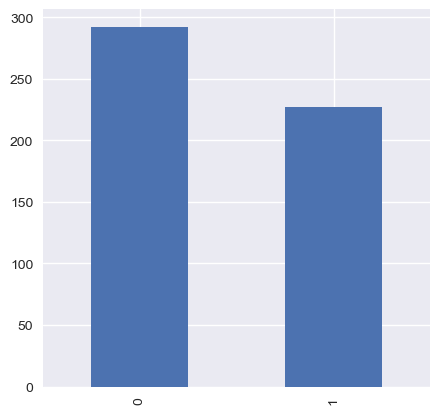

In [15]:
print(train['label'].value_counts())
plt.figure(figsize=(5,5), dpi=100)
train['label'].value_counts().plot(kind='bar')

0    77
1    53
Name: label, dtype: int64


<AxesSubplot:>

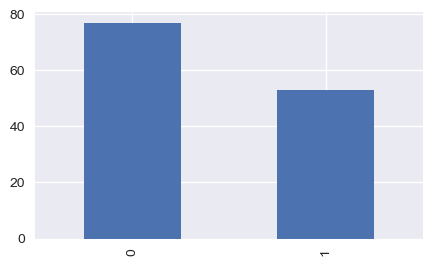

In [16]:
print(test['label'].value_counts())
plt.figure(figsize=(5,3), dpi=100)
test['label'].value_counts().plot(kind='bar')

In [17]:
non_sensitive_train = train[train['label'] == 0]
sensitive_train = train[train['label'] == 1]

In [18]:
non_sensitive_train

,content,label
278,"[revenue, important, aspect, project, survive,...",0
95,"[ada, opportunity, dekat, oversea, gerak, je, ...",0
620,"[yes, proud, domenico, mondelli, afro, america...",0
224,"[100, going, woman, equality]",0
168,"[past, year, ha, undeniably, challenging, test...",0
...,...,...
264,"[6, passive, income, idea, software, developer]",0
9,"[exchange, completely, correct, valuable, cpd,...",0
107,"[good, coach, started, lower, level, school, t...",0
47,"[spent, much, time, someone, week, back, work,...",0


In [19]:
# non_sensitive_train_part = non_sensitive_train['content'].sample(139, random_state=42)
# sensitive_train_part = sensitive_train['content'].sample(139, random_state=42)

non_sensitive_trainset = non_sensitive_train['content']
sensitive_trainset = sensitive_train['content']

vocablist = []
for i in pd.concat([non_sensitive_trainset, sensitive_trainset]):
    vocablist += i

In [20]:
vocablist

['revenue',
 'important',
 'aspect',
 'project',
 'survive',
 'maintain',
 'project',
 'company',
 'way',
 'generate',
 'profit',
 'revenue',
 'token',
 'income',
 'model',
 'ada',
 'opportunity',
 'dekat',
 'oversea',
 'gerak',
 'je',
 'boleh',
 'nak',
 'fight',
 'untuk',
 'salary',
 'dekat',
 'malaysia',
 'tapi',
 'tak',
 'berbaloi',
 'yang',
 'still',
 'ada',
 'energy',
 'nak',
 'fight',
 'good',
 'luck',
 'yes',
 'proud',
 'domenico',
 'mondelli',
 'afro',
 'american',
 'proud',
 'jesse',
 'owen',
 'lofty',
 'humane',
 'podium',
 'struggle',
 'liberty',
 'equality',
 'amp',
 'fraternity',
 'deserve',
 'amp',
 'aspire',
 'planet',
 'history',
 '100',
 'going',
 'woman',
 'equality',
 'past',
 'year',
 'ha',
 'undeniably',
 'challenging',
 'testing',
 'physical',
 'mental',
 'emotional',
 'health',
 'help',
 'motivational',
 'advice',
 'savvy',
 'strategy',
 'staving',
 'burnout',
 'turned',
 'brittnea',
 'jones',
 'parkview',
 'behavioral',
 'health',
 'institute',
 'love',
 'decora

In [21]:
trainset_texts = [' '.join(content) for content in np.concatenate((non_sensitive_trainset.values, sensitive_trainset.values))]

train_all_texts = [' '.join(content) for content in train['content']]

test_all_texts = [' '. join(content) for content in test['content']]


In [22]:
trainset_texts

['revenue important aspect project survive maintain project company way generate profit revenue token income model',
 'ada opportunity dekat oversea gerak je boleh nak fight untuk salary dekat malaysia tapi tak berbaloi yang still ada energy nak fight good luck',
 'yes proud domenico mondelli afro american proud jesse owen lofty humane podium struggle liberty equality amp fraternity deserve amp aspire planet history',
 '100 going woman equality',
 'past year ha undeniably challenging testing physical mental emotional health help motivational advice savvy strategy staving burnout turned brittnea jones parkview behavioral health institute',
 'love decorating house living best moment life want thank dad workmate bc one pay nintendo switch online expansion pack whatever called dlc',
 'best former bos ex manager look mastermind fa cup upset afternoon',
 'rajasthan teacher lost job supporting pakistan t20 world cup say family member also',
 'kek live btw linky bio ds3 bos grind',
 'great job

In [23]:
cv = CountVectorizer()
trainset_fit = cv.fit(trainset_texts)
train_all_count = cv.transform(train_all_texts)
test_all_count = cv.transform(test_all_texts)

In [24]:
train_all_count

<519x3476 sparse matrix of type '<class 'numpy.int64'>'
	with 7788 stored elements in Compressed Sparse Row format>

In [25]:
tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)
test_tfidf_matrix = tfidf.fit_transform(test_all_count)

In [26]:
train_tfidf_matrix

<519x3476 sparse matrix of type '<class 'numpy.float64'>'
	with 7788 stored elements in Compressed Sparse Row format>

In [71]:
model = MultinomialNB(alpha=1.15, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)

In [72]:
model.score(test_tfidf_matrix, y_test)

0.8307692307692308

In [29]:
pred = model.predict(test_tfidf_matrix)
acc = 1 - np.sum(np.abs(y_test - pred)) / len(y_test)
print(acc)

0.8384615384615385


In [30]:
from sklearn import datasets,linear_model,svm

def test_LinearSVC(*data):
    x_train,x_test,y_train,y_test=data
    cls=svm.LinearSVC()
    cls.fit(x_train,y_train)
    print('SVM')
    print('Coefficients:%s, intercept %s'%(cls.coef_,cls.intercept_))
    print('Score: %.2f' % cls.score(x_test, y_test))


test_LinearSVC(train_tfidf_matrix,test_tfidf_matrix,y_train,y_test)   

SVM
Coefficients:[[ 0.11802659  0.41874939 -0.42630149 ... -0.09084663  0.08804464
  -0.20075535]], intercept [-0.27568404]
Score: 0.83


In [31]:
def test_SVC_Linear(*data):
    x_train,x_test,y_train,y_test=data
    cls=svm.SVC(kernel='linear')
    cls.fit(x_train,y_train)
    print('non-linear SVM')
    # print('Coefficients:%s, intercept %s'%(cls.coef_,cls.intercept_))
    print('Score: %.2f' % cls.score(x_test, y_test))

test_SVC_Linear(train_tfidf_matrix,test_tfidf_matrix,y_train,y_test)

non-linear SVM
Score: 0.82


In [46]:
from sklearn.neighbors import KNeighborsClassifier
#KNN, neuighbors=10
knn = KNeighborsClassifier(n_neighbors=15)

knn.fit(train_tfidf_matrix, y_train)
knn.score(test_tfidf_matrix, y_test)

0.7230769230769231

In [40]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time

    
from sklearn import metrics

NBM = [SVC(kernel='linear', C=0.8), 
       SVC(kernel='rbf', gamma='auto'),
       SVC(kernel='poly', degree=3), 
       KNeighborsClassifier(n_neighbors=13), 
       MultinomialNB(alpha=1.1, fit_prior=True, class_prior=None),
       DecisionTreeClassifier(max_depth=10, min_samples_split=4), #防止过拟合将树深设为10
       AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, min_samples_split=5),
                                                 n_estimators=100, learning_rate=1),#选择决策树，迭代000次，学习率为0.8
       RandomForestClassifier(n_estimators= 200, max_depth=10)]
NAME= ["LINEAR","RBF","poly", "KNN_N11", "MNB","DCT", "Boosting_Ada", "Bagging_RF"]
for itr, itrname in zip(NBM, NAME):
    #训练过程
    print("Training...")
    t1 = time.perf_counter()
    itr.fit(train_tfidf_matrix, y_train)
    t2 = time.perf_counter()
    print("Applying...")
    y_train_pdt = itr.predict(train_tfidf_matrix)
    t3 = time.perf_counter()
    y_test_pdt = itr.predict(test_tfidf_matrix)

    dts1 = len(np.where(y_train_pdt==y_train)[0])/len(y_train)
    dts2 = len(np.where(y_test_pdt==y_test)[0])/len(y_test)
    
    acc1 = accuracy_score(y_train_pdt, y_train)
    acc2 = accuracy_score(y_test_pdt, y_test)
    
    pre1 = precision_score(y_train_pdt, y_train)
    pre2 = precision_score(y_test_pdt, y_test)
    
    rec1 = recall_score(y_train_pdt, y_train)
    rec2 = recall_score(y_test_pdt, y_test)

    print("model_train：{} accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, time：{:.2f}s".format(itrname, acc1*100, pre1*100, rec1*100, t2 - t1))
    print("model_test：{} accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, time：{:.2f}s".format(itrname, acc2*100, pre2*100, rec2*100, t3 - t2))
    


Training...
Applying...
model_train：LINEAR accuracy:97.688%, precision:95.595%, recall:99.087%, time：0.04s
model_test：LINEAR accuracy:81.538%, precision:66.038%, recall:85.366%, time：0.04s
Training...
Applying...
model_train：RBF accuracy:56.262%, precision:0.000%, recall:0.000%, time：0.04s
model_test：RBF accuracy:59.231%, precision:0.000%, recall:0.000%, time：0.03s
Training...


/Users/yhl125/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Applying...
model_train：poly accuracy:100.000%, precision:100.000%, recall:100.000%, time：0.04s
model_test：poly accuracy:63.077%, precision:9.434%, recall:100.000%, time：0.04s
Training...
Applying...
model_train：KNN_N11 accuracy:76.301%, precision:59.031%, recall:81.707%, time：0.00s
model_test：KNN_N11 accuracy:76.154%, precision:62.264%, recall:75.000%, time：0.02s
Training...
Applying...
model_train：MNB accuracy:98.266%, precision:96.476%, recall:99.545%, time：0.00s
model_test：MNB accuracy:83.846%, precision:67.925%, recall:90.000%, time：0.00s
Training...
Applying...
model_train：DCT accuracy:83.815%, precision:62.996%, recall:100.000%, time：0.01s
model_test：DCT accuracy:73.077%, precision:47.170%, recall:78.125%, time：0.00s
Training...
Applying...
model_train：Boosting_Ada accuracy:100.000%, precision:100.000%, recall:100.000%, time：1.32s
model_test：Boosting_Ada accuracy:63.846%, precision:73.585%, recall:54.167%, time：0.03s
Training...
Applying...
model_train：Bagging_RF accuracy:76.686

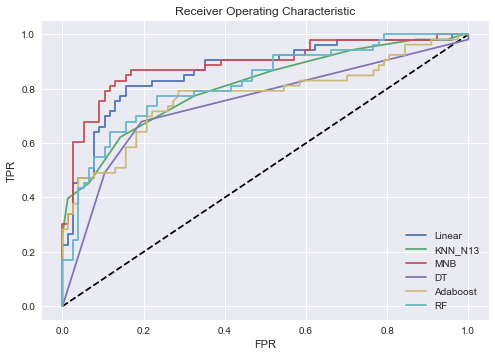

In [124]:
#ROC Curve
from sklearn.metrics import roc_curve
classifier1 = SVC(kernel='linear', C=0.5, probability=True).fit(train_tfidf_matrix, y_train)
y_pred_prob1 = classifier1.predict_proba(test_tfidf_matrix)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

classifier2 = SVC(kernel='rbf', C=0.5, probability=True).fit(train_tfidf_matrix, y_train)
y_pred_prob2 = classifier2.predict_proba(test_tfidf_matrix)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

classifier3 = KNeighborsClassifier(n_neighbors=13).fit(train_tfidf_matrix, y_train)
y_pred_prob3 = classifier3.predict_proba(test_tfidf_matrix)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

classifier4 = MultinomialNB(alpha=1.1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)
y_pred_prob4 = classifier4.predict_proba(test_tfidf_matrix)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

classifier5 = DecisionTreeClassifier(max_depth=10, min_samples_split=4).fit(train_tfidf_matrix, y_train)
y_pred_prob5 = classifier5.predict_proba(test_tfidf_matrix)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)

classifier6 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, min_samples_split=5),
                                                 n_estimators=100, learning_rate=1).fit(train_tfidf_matrix, y_train)
y_pred_prob6 = classifier6.predict_proba(test_tfidf_matrix)[:,1]
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred_prob6)

classifier7 = RandomForestClassifier(n_estimators= 200, max_depth=10).fit(train_tfidf_matrix, y_train)
y_pred_prob7 = classifier7.predict_proba(test_tfidf_matrix)[:,1]
fpr7 , tpr7, thresholds7 = roc_curve(y_test, y_pred_prob7)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Linear")
#plt.plot(fpr2, tpr2, label= "Poly")
plt.plot(fpr3, tpr3, label= "KNN_N13")
plt.plot(fpr4, tpr4, label= "MNB")
plt.plot(fpr5, tpr5, label= "DT")
plt.plot(fpr6, tpr6, label= "Adaboost")
plt.plot(fpr7, tpr7, label= "RF")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()


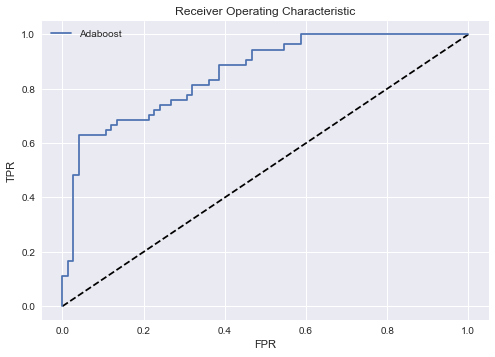

In [36]:
classifier6 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, min_samples_split=5),
                                                 n_estimators=100, learning_rate=1).fit(train_tfidf_matrix, y_train)
y_pred_prob6 = classifier6.predict_proba(test_tfidf_matrix)[:,1]
fpr6 , tpr6, thresholds6 = roc_curve(y_test, y_pred_prob4)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr6, tpr6, label= "Adaboost")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [37]:
clf = MultinomialNB(alpha=1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)
clf.score(test_tfidf_matrix, y_test)

0.813953488372093

In [40]:
#text = "@Alice My name is Bob, I work in Microsoft. #highqualityman https:bscn3789de.com"
#text = "Today is my Birthday."
#text = "My salary is $2000 per month"
#text = "My boss Roan is a foolish man"
#text = "I hope Alice get fired tommorrow"
#text = "My workmate is nice"
#text = "My workmate is bad"
#text = "My workmate is shameless"
#text = "My employee John is good"
#text = "My employee John is good but stupid"
#text = "My employee John is stupid, but he pays me a lot"



df = pd.DataFrame({"text":text},index=["0"])

df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))
df['text'] = df['text'].apply(text_process)
print(df['text'])


0    [employee, john, good, stupid]
Name: text, dtype: object


In [47]:
print(df['text'])
text_content = [' '.join(content) for content in df['text']]
print(text_content)
print('---')

text_count = cv.transform(text_content)
print(text_count)
print('+++')
text_tfidf_matrix = tfidf.fit_transform(text_count)
pre = clf.predict(text_tfidf_matrix)
print(pre)


0    [employee, john, good, stupid]
Name: text, dtype: object
['employee john good stupid']
---
  (0, 855)	1
  (0, 1116)	1
  (0, 2490)	1
+++
[1]


In [37]:
doc = nlp(text)
print(*[f'entity: {ent.text}\ttype: {ent.type}' for sent in doc.sentences for ent in sent.ents], sep='\n')
for ent in doc.ents:
    if ent.type == 'PERSON':
        print("You may leak 'name' information.")
    if ent.type == 'MONEY':
        print("You may leak 'money' information.")

entity: 2000	type: MONEY
You may leak 'money' information.
